# Statup

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd "gdrive/MyDrive/da2/task_2"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1uoqnB7hDMLLiVIqC8KX-jfa_Xz9gRAMR/da2/task_2


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator

from src.d01_data import load_data, save_data
from src.d02_processing import preprocess, postprocess, sliding_window
from src.d03_model import transfer_learning
from src.d04_visualization import bounding_box
from src.d05_evaluation import evaluate_predictions

# Data

In [3]:
dataset = load_data.load_train_data()

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [4]:
classes = ["background", "pond", "pools", "solar", "trampoline"]

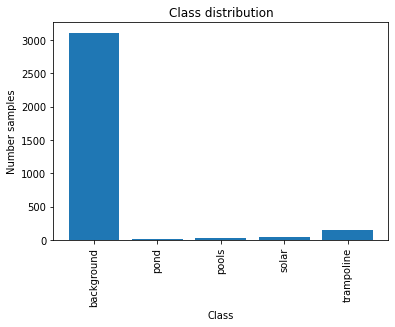

In [ ]:
labels = np.array([y.numpy() for x, y in dataset])
label_count = np.unique(labels, return_counts=True)

plt.bar(classes, label_count[1])
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Number samples")
plt.xticks(rotation=90)
plt.show()

# Preprocess

In [5]:
base_model = transfer_learning.get_model()

82436096/82420632 [==============================] - 1s 0us/step


In [16]:
data_train, data_val = preprocess.preprocess_train(dataset)

# Preprocess Testing
##### Does **not** work without custom variable assignments

test


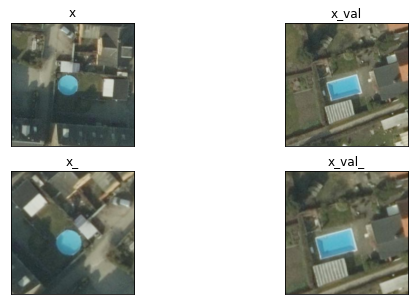

In [ ]:
fig = plt.figure(figsize=(9, 5))

d_x = rel.take(1)
d_x_ = data_train.take(1)
d_x_val = rel.skip(int(206 * 0.7)).take(1)
d_x_val_ = data_val.take(1)

for x,y in d_x:
  f = fig.add_subplot(2, 2, 1)
  plt.imshow(x)
  f.set_title("x")
  f.xaxis.set_visible(False)
  f.yaxis.set_visible(False)

for x,y in d_x_val:
  f = fig.add_subplot(2, 2, 2)
  plt.imshow(x)
  f.set_title("x_val")
  f.xaxis.set_visible(False)
  f.yaxis.set_visible(False)

for x,y in d_x_:
  f = fig.add_subplot(2, 2, 3)
  plt.imshow(tf.cast(x, tf.uint8))
  f.set_title("x_")
  f.xaxis.set_visible(False)
  f.yaxis.set_visible(False)

for x,y in d_x_val_:
  f = fig.add_subplot(2, 2, 4)
  plt.imshow(tf.cast(x, tf.uint8))
  f.set_title("x_val_")
  f.xaxis.set_visible(False)
  f.yaxis.set_visible(False)

plt.show()

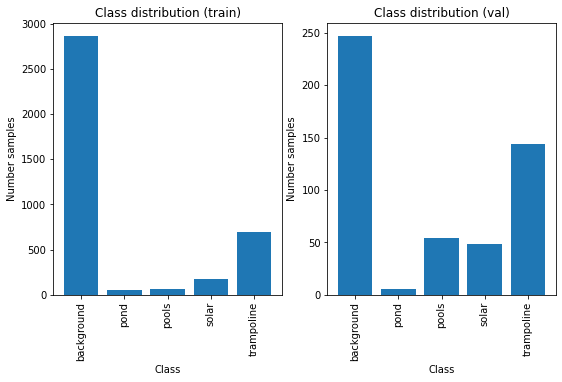

In [19]:
fig = plt.figure(figsize=(9, 5))
fig.add_subplot(1, 2, 1)
labels = np.array([np.argmax(y.numpy()) for x, y in data_train.unbatch()])
label_count = np.unique(labels, return_counts=True)
plt.bar(classes, label_count[1])
plt.title("Class distribution (train)")
plt.xlabel("Class")
plt.ylabel("Number samples")
plt.xticks(rotation=90)

fig.add_subplot(1, 2, 2)
labels = np.array([np.argmax(y.numpy()) for x, y in data_val.unbatch()])
label_count = np.unique(labels, return_counts=True)
plt.bar(classes, label_count[1])
plt.title("Class distribution (val)")
plt.xlabel("Class")
plt.ylabel("Number samples")
plt.xticks(rotation=90)

plt.show()

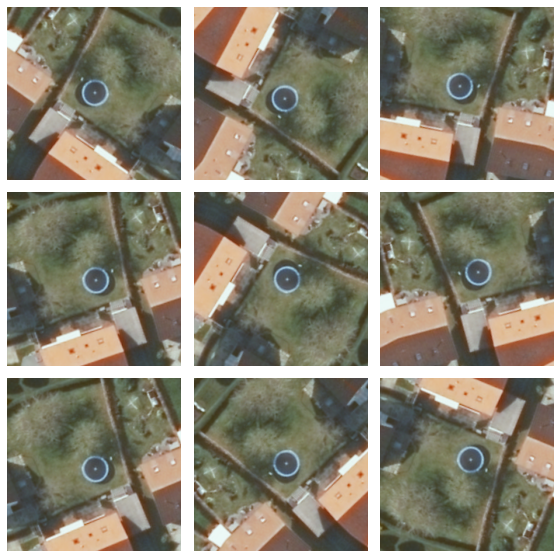

In [ ]:
#Data augmentation
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.4),
    keras.layers.RandomCrop(224, 224)
])

from PIL import Image
image=Image.open("data/training_patches/train/trampoline/02LHCT.png")
image = np.asarray(image)/255
image = tf.cast(tf.expand_dims(image, 0), tf.float32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.subplots_adjust(hspace=0.07, wspace=0.01)
  plt.imshow(augmented_image[0])
  plt.axis("off")
  #plt.savefig('data_augmentation.png', dpi=700)

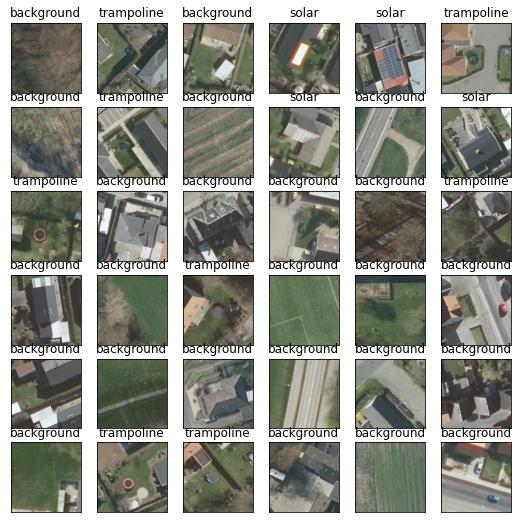

In [21]:
subplot_i = 1

fig = plt.figure(figsize=(9, 9))
for x,y in data_train.unbatch():
  f = fig.add_subplot(6, 6, subplot_i)
  plt.imshow(x)
  f.set_title(classes[np.argmax(y)])
  f.xaxis.set_visible(False)
  f.yaxis.set_visible(False)

  if subplot_i == 36:
    break
  subplot_i += 1

plt.show()

# Classifier

In [33]:
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization

model = keras.models.Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(5, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

In [34]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_12 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                     

In [35]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [36]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = model.fit(data_train, epochs=6, validation_data=data_val, callbacks=[es_callback])

Epoch 1/6
121/121 [==============================] - 85s 242ms/step - loss: 0.8592 - accuracy: 0.7115 - val_loss: 0.2343 - val_accuracy: 0.9319
Epoch 2/6
121/121 [==============================] - 71s 207ms/step - loss: 0.2690 - accuracy: 0.9410 - val_loss: 0.2175 - val_accuracy: 0.9419
Epoch 3/6
121/121 [==============================] - 71s 210ms/step - loss: 0.2204 - accuracy: 0.9446 - val_loss: 0.1824 - val_accuracy: 0.9539
Epoch 4/6
121/121 [==============================] - 68s 207ms/step - loss: 0.1749 - accuracy: 0.9555 - val_loss: 0.2078 - val_accuracy: 0.9479
Epoch 5/6
121/121 [==============================] - 69s 213ms/step - loss: 0.1830 - accuracy: 0.9537 - val_loss: 0.1787 - val_accuracy: 0.9459
Epoch 6/6
121/121 [==============================] - 67s 211ms/step - loss: 0.1595 - accuracy: 0.9568 - val_loss: 0.1956 - val_accuracy: 0.9499


In [37]:
for layer in base_model.layers:
    layer.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

In [38]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_12 (Bat  (None, 1280)             5120      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                     

In [42]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history2 = model.fit(data_train, epochs=2, validation_data=data_val, callbacks=[es_callback])

Epoch 1/2
121/121 [==============================] - 83s 235ms/step - loss: 0.1413 - accuracy: 0.9626 - val_loss: 0.1730 - val_accuracy: 0.9599
Epoch 2/2
121/121 [==============================] - 69s 212ms/step - loss: 0.1284 - accuracy: 0.9675 - val_loss: 0.1688 - val_accuracy: 0.9619


In [14]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [15]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history3 = model.fit(data_train, epochs=20, validation_data=data_val, callbacks=[es_callback])

Epoch 1/20
121/121 [==============================] - 83s 240ms/step - loss: 0.3075 - accuracy: 0.9056 - val_loss: 0.2176 - val_accuracy: 0.9259
Epoch 2/20
121/121 [==============================] - 70s 220ms/step - loss: 0.2481 - accuracy: 0.9270 - val_loss: 0.1447 - val_accuracy: 0.9579
Epoch 3/20
121/121 [==============================] - 70s 215ms/step - loss: 0.1639 - accuracy: 0.9545 - val_loss: 0.1899 - val_accuracy: 0.9459
Epoch 4/20
121/121 [==============================] - 69s 214ms/step - loss: 0.1552 - accuracy: 0.9553 - val_loss: 0.2431 - val_accuracy: 0.9299
Epoch 5/20
121/121 [==============================] - 68s 214ms/step - loss: 0.1315 - accuracy: 0.9639 - val_loss: 0.1666 - val_accuracy: 0.9559
Epoch 6/20
121/121 [==============================] - 67s 216ms/step - loss: 0.1273 - accuracy: 0.9631 - val_loss: 0.2767 - val_accuracy: 0.9359


# Save model

In [19]:
model.save(os.path.join(os.getcwd(), "models", "efficientnet_v2_9"))

INFO:tensorflow:Assets written to: /content/gdrive/.shortcut-targets-by-id/1uoqnB7hDMLLiVIqC8KX-jfa_Xz9gRAMR/da2/task_2/models/efficientnet_v2_8/assets


INFO:tensorflow:Assets written to: /content/gdrive/.shortcut-targets-by-id/1uoqnB7hDMLLiVIqC8KX-jfa_Xz9gRAMR/da2/task_2/models/efficientnet_v2_8/assets


In [44]:
model = keras.models.load_model(os.path.join(os.getcwd(), "models", "efficientnet_v2_7"))

# Sliding Window

In [ ]:
pred = np.load(os.path.join(os.getcwd(), 'data', 'predictions.npy'))
confidence = np.load(os.path.join(os.getcwd(), 'data', 'confidence.npy'))

In [ ]:
img = np.asarray(Image.open(os.path.join(os.getcwd(), 'data','val','DQIMQN.png')))

In [ ]:
pred, confidence = sliding_window.find_classes(img, model, 256, 121, (224, 224)) #64 44 88

Iteration: 10 of 65
Iteration: 20 of 65
Iteration: 30 of 65
Iteration: 40 of 65
Iteration: 50 of 65
Iteration: 60 of 65


In [ ]:
for y, l in enumerate(pred):
  print(*l, y)
  # for x, p in enumerate(l):
  #   if p != 0:
  #     print(x, y, p)
  #     break
print(*range(10), *range(10), *range(10), *range(10), *range(10), *range(10), *range(5))

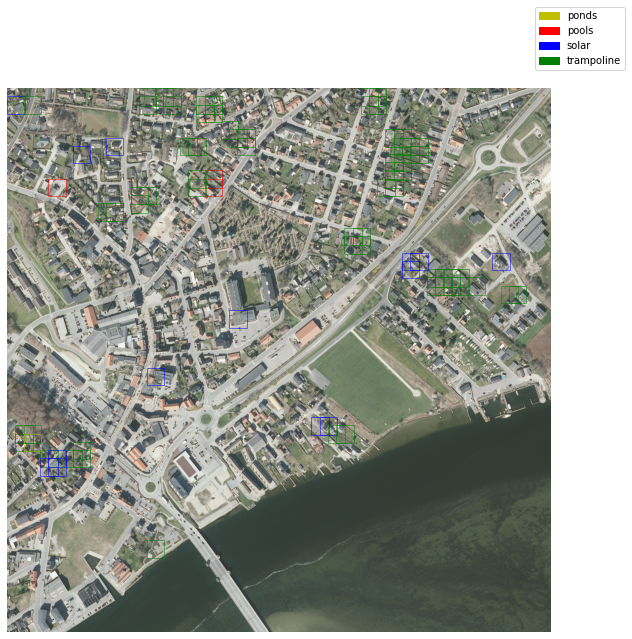

In [ ]:
bounding_box.draw(img, pred, 121, save=True)

In [ ]:
boxes = postprocess.merge_predictions(pred, confidence, min_confidence=0.6, n_range_per_class={1:1, 2:1, 3:1, 4:2})
print(len(boxes))  # 161

29


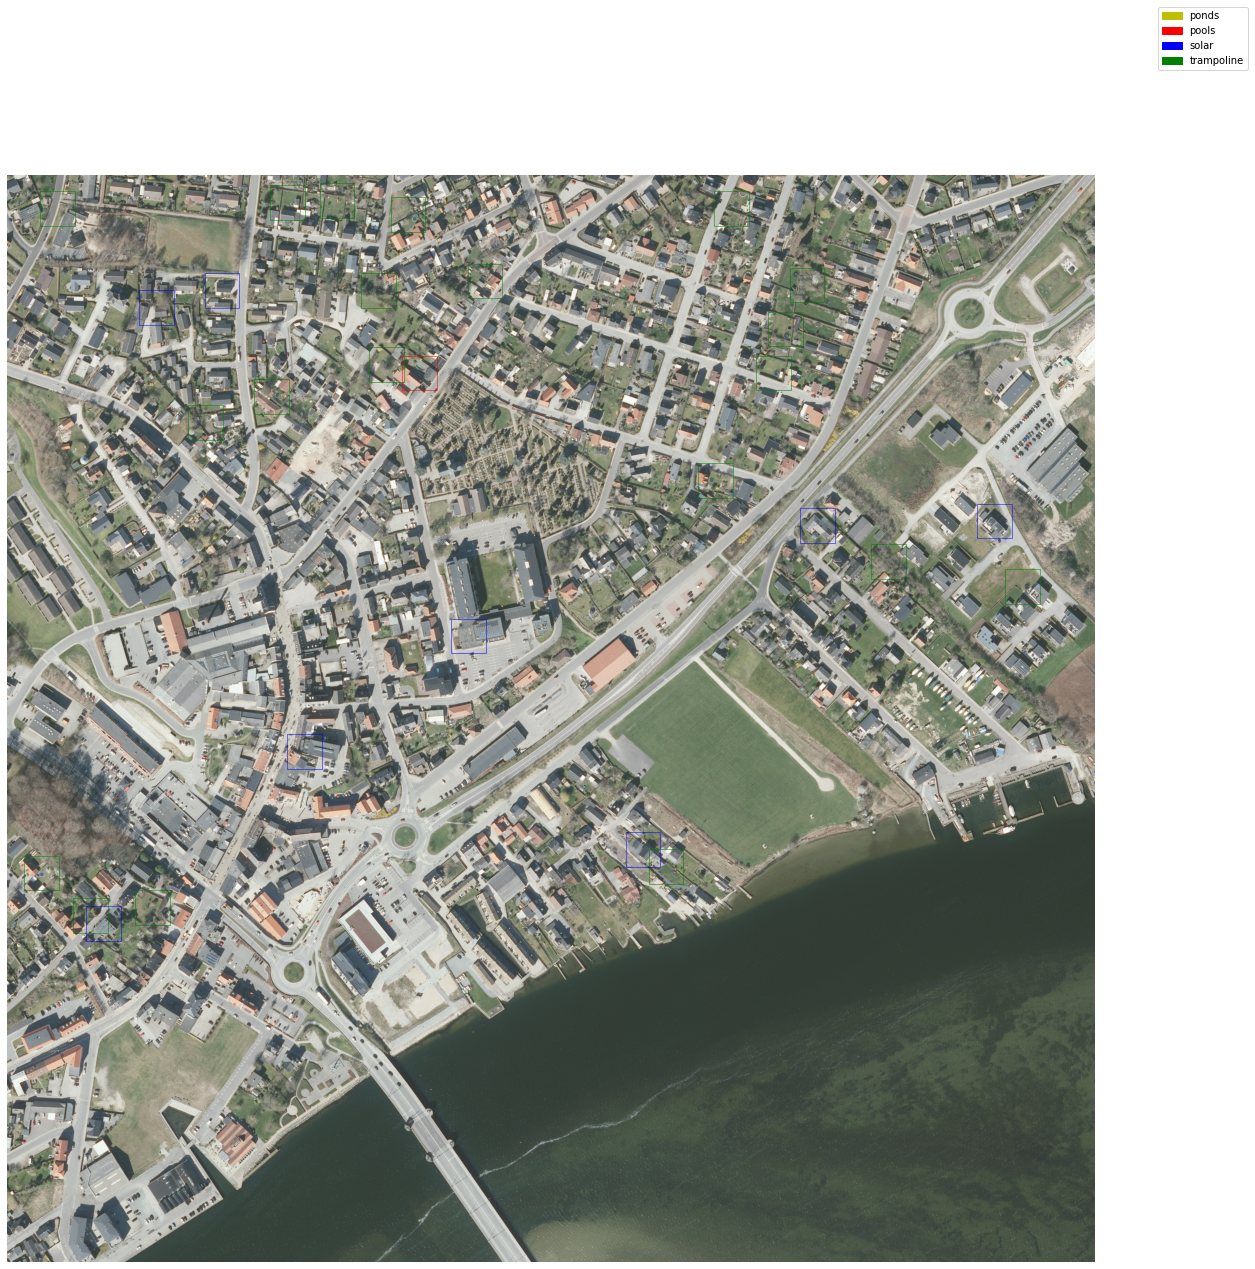

In [ ]:
bounding_box.draw_boxes(img, boxes, 121, save=True)

In [ ]:
boxes = sliding_window.apply_nms(pred, confidence)
print(len(boxes))  # 161

155


In [ ]:
bounding_box.draw_boxes(img, boxes, 121, save=False)

In [53]:
def check(val_image, min_confidence=0.6):
  # pred = np.load(os.path.join(os.getcwd(), 'out', val_image, 'predictions.npy'))
  # confidence = np.load(os.path.join(os.getcwd(), 'out', val_image, 'confidence.npy'))

  img = np.asarray(Image.open(os.path.join(os.getcwd(), 'data','val',val_image + '.png')))
  pred, confidence = sliding_window.find_classes(img, model, 256, 121, (224, 224)) #64 44 88

  count = 0
  for p in pred.flatten():
    if p > 0:
      count += 1

  print(count)
  boxes = postprocess.merge_predictions(pred, confidence, min_confidence=min_confidence, n_range_per_class={1:1, 2:1, 3:1, 4:2})
  # boxes = sliding_window.apply_nms(pred, confidence, num_boxes=count)
  print("#Boxes:", len(boxes))

  save_data.save_boxes(boxes, os.path.join(os.getcwd(), 'out', 'prepared', val_image + '.csv'))  

  return evaluate_predictions.calc_performance(
    os.path.join(os.getcwd(), 'data', 'val', val_image + '.csv'),
    os.path.join(os.getcwd(), 'out', 'prepared', val_image + '.csv')
  )

In [54]:
# L7CT2I # UDPYYD
check('DQIMQN')  #DQIMQN: best until now (min_conf=06): {'f1': 0.6956521740453686, 'file': None, 'fn': 14, 'fp': 0, 'tp': 16}

Iteration: 10 of 65
Iteration: 20 of 65
Iteration: 30 of 65
Iteration: 40 of 65
Iteration: 50 of 65
Iteration: 60 of 65
84
#Boxes: 29


{'f1': 0.6956521740453686, 'file': None, 'fn': 14, 'fp': 0, 'tp': 16}

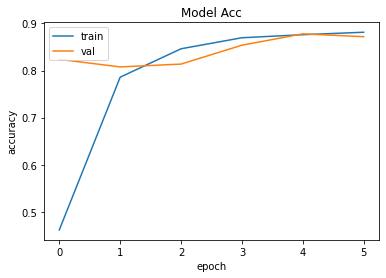

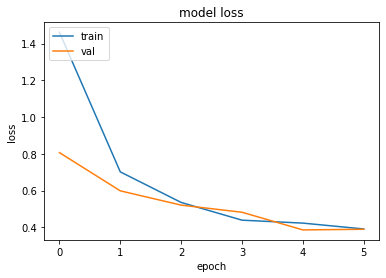

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axvline(x=12, linestyle='--', color='gray')
plt.title('Model Acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png', dpi=500)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.axvline(x=12, linestyle='--', color='gray')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png', dpi=500)
plt.show()

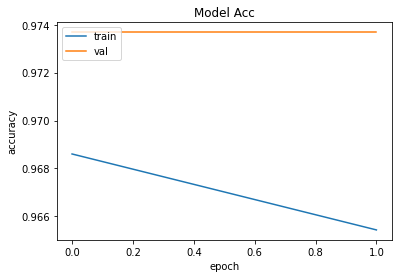

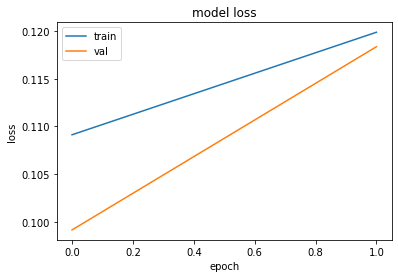

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
#plt.axvline(x=12, linestyle='--', color='gray')
plt.title('Model Acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png', dpi=500)
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
#plt.axvline(x=12, linestyle='--', color='gray')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png', dpi=500)
plt.show()